# **Feature extraction**

## **This Notebook**
In this notebook we will perfom feature extraction
- HSV - Color Diagram
- HOG - Histogram of Oriented Gradients

### **1.1 Import necessary libaries**

In [1]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import requests
import scipy.cluster.hierarchy as sch
import openai
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer
import random
import cv2
from skimage.feature import hog
from skimage import data, exposure

/Users/richardlumpi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### **1.2 Load the dataset**

In [2]:
df = pd.read_csv('movie_df_clean.csv')

In [3]:
# List of images
images = []


# Iterate over each movie ID in the 'tconst' column of the DataFrame
for id in df['tconst']:
    try: 
        # Construct the image file path based on the movie ID
        image_path = 'Data/WithText/' + id + '.jpg'

        # Open the image file
        image = Image.open(image_path)

        
        image_bgr = cv2.imread(image_path)
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 450))
        
        # Add to images
        images.append(image)

        # Convert the image into a NumPy array
        image_array = np.array(image)

       
    # Handle the case where the image file is missing
    except FileNotFoundError:
        # Remove the row corresponding to the missing poster from the DataFrame
        df = df[df["tconst"] != id]

    # Handle cases where the image file is corrupted or not a valid image
    except UnidentifiedImageError:
        # Remove the row corresponding to the invalid poster from the DataFrame
        df = df[df["tconst"] != id]

        # Delete the corrupted or unrecognized image file from the directory
        # os.remove(image_path)

In [4]:
histograms = []
histograms_summary = []

for i, id in enumerate(df['tconst']):

    image_path = 'Data/WithText/' + id + '.jpg'
    im = Image.open(image_path)
    
    # Convert image to HSV
    image = np.array(im.convert("RGB"))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    im.close()
    
    # Compute HSV histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, (32, 32, 32), [0, 180, 0, 256, 0, 256])
    hist = hist / np.sum(hist)
    
    hue_channel = np.sum(hist, axis=(1, 2))
    saturation_channel = np.sum(hist, axis=(0, 2))
    value_channel = np.sum(hist, axis=(0, 1))
    
    histograms.append(np.concatenate((hue_channel, saturation_channel, value_channel)))
    
    # Compute moments for each channel (H, S, V)
    moments = []
    for i in range(3):  # H, S, V channels
        channel = image[:, :, i]
        moments.append(np.mean(channel))
        moments.append(np.std(channel))
        moments.append(np.mean((channel - np.mean(channel))**3)) 
   
    histograms_summary.append(np.array(moments))
    

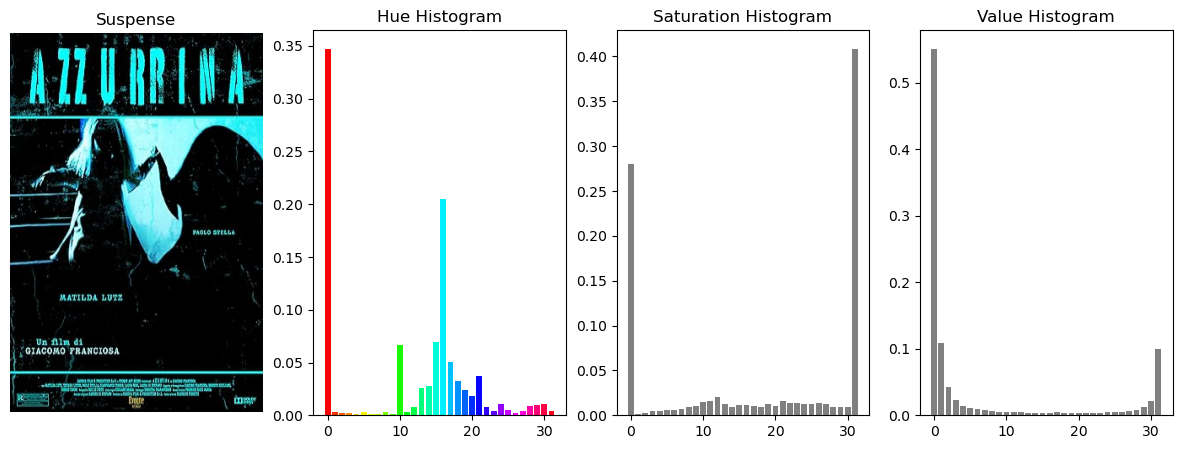

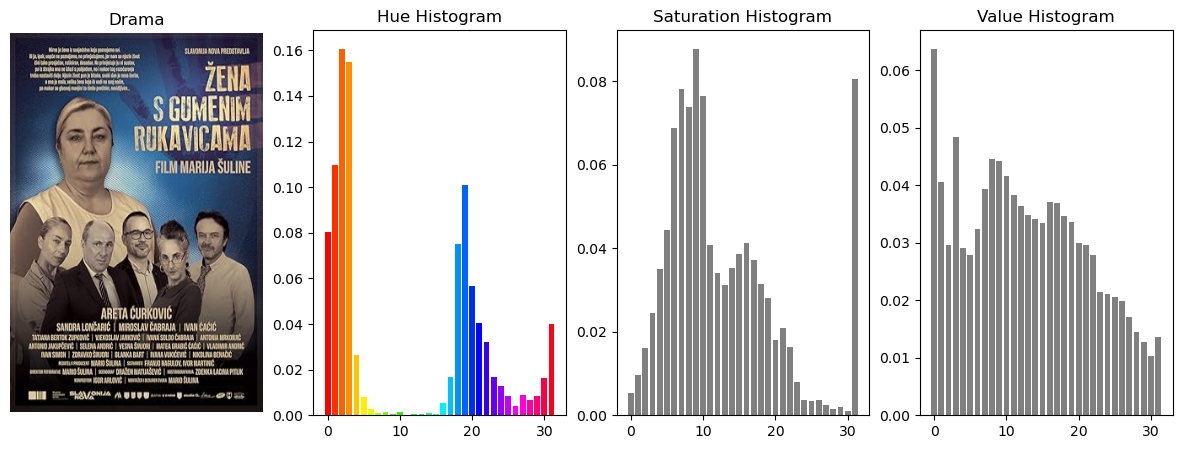

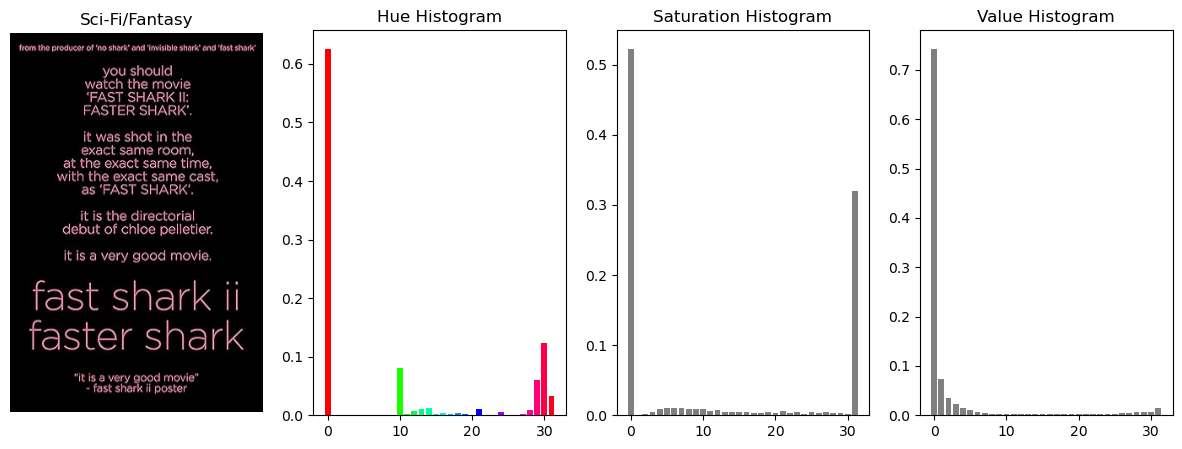

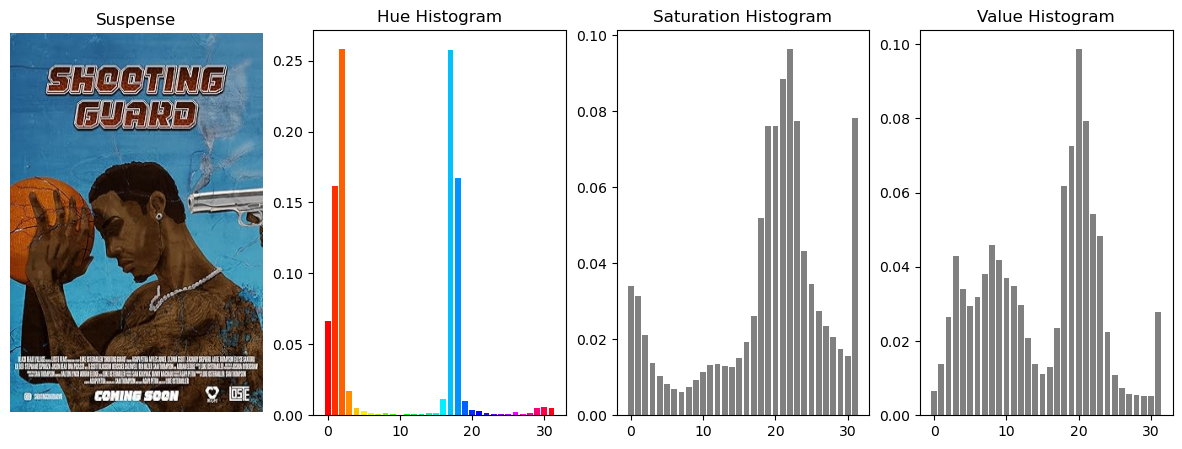

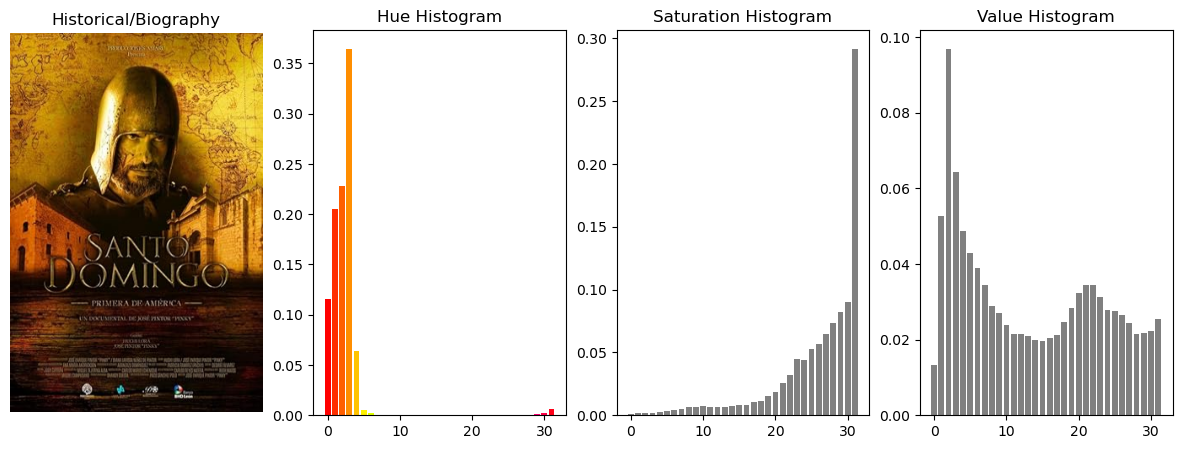

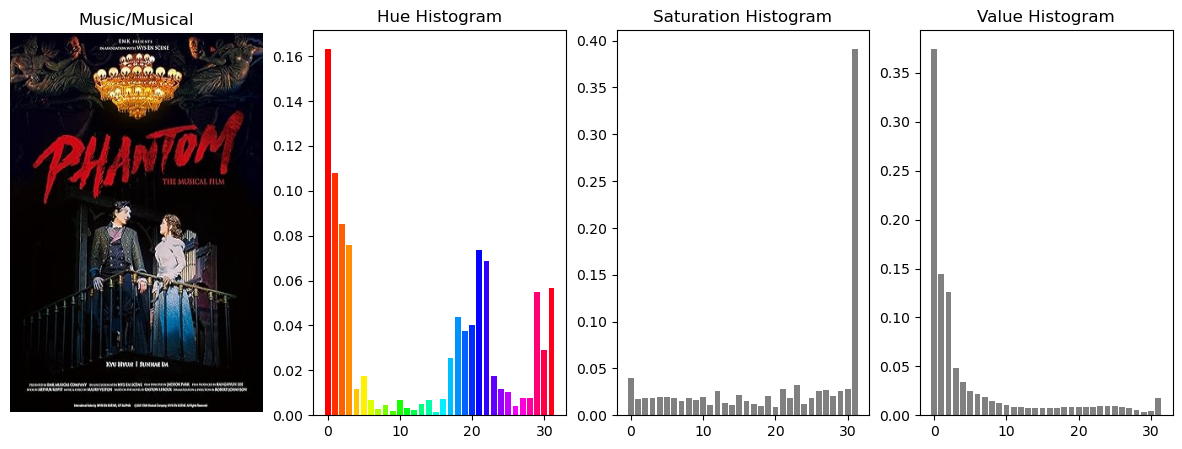

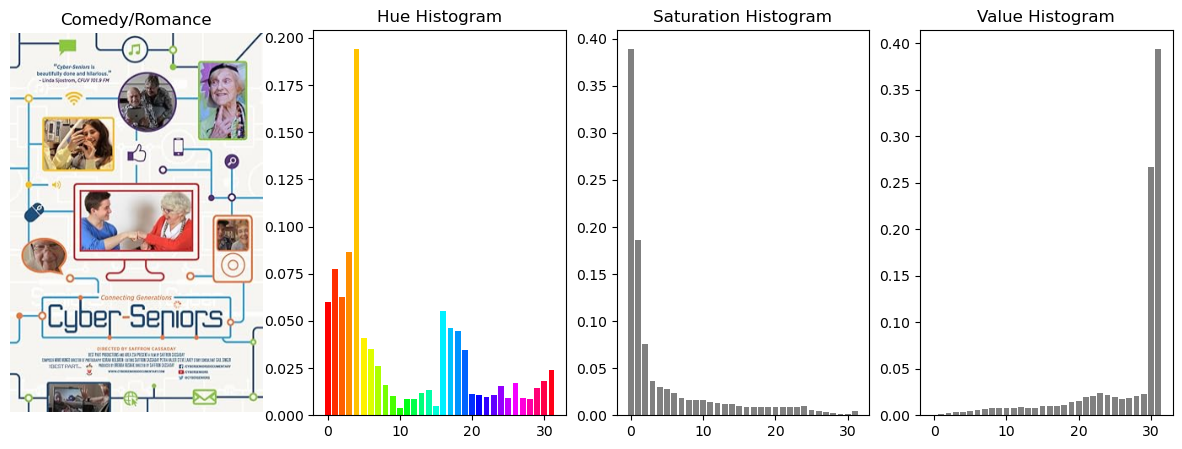

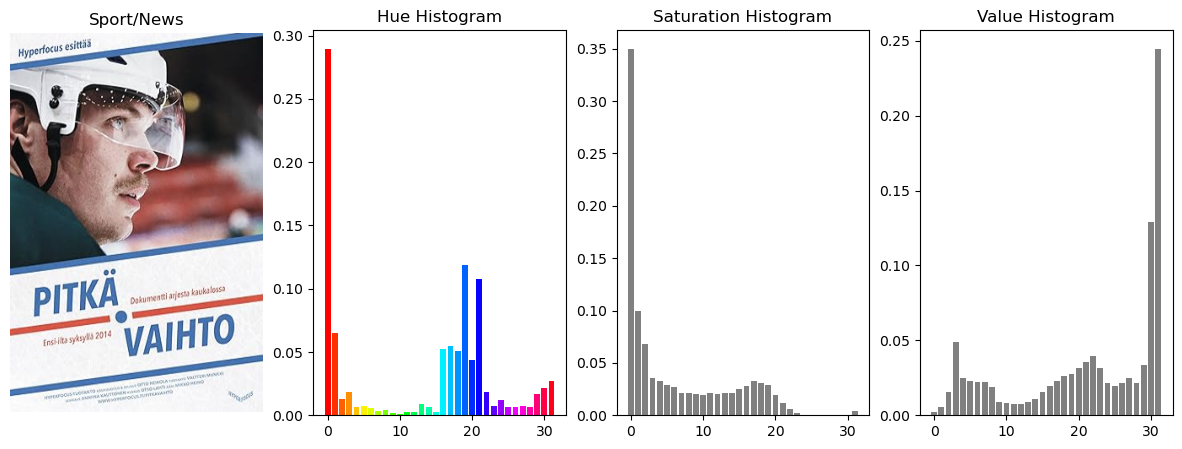

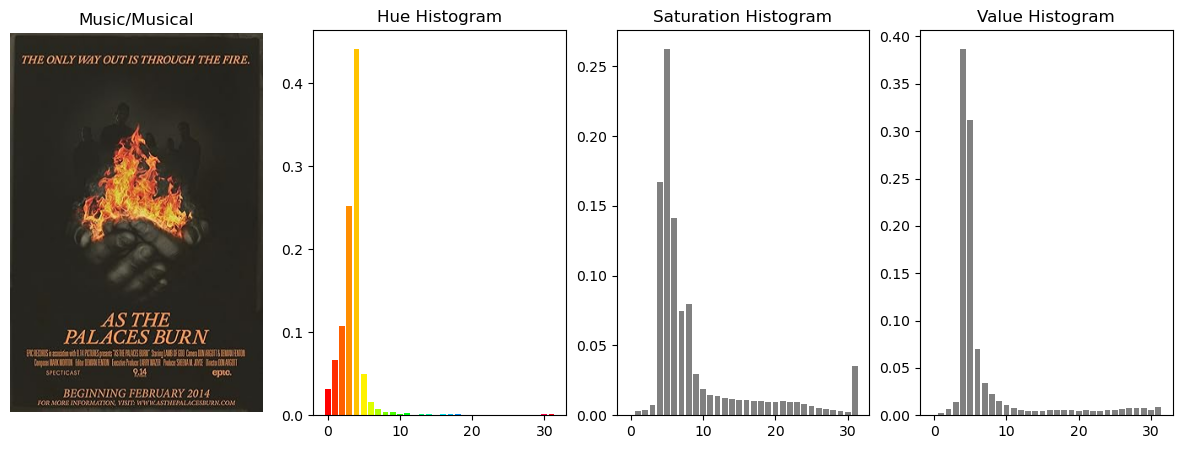

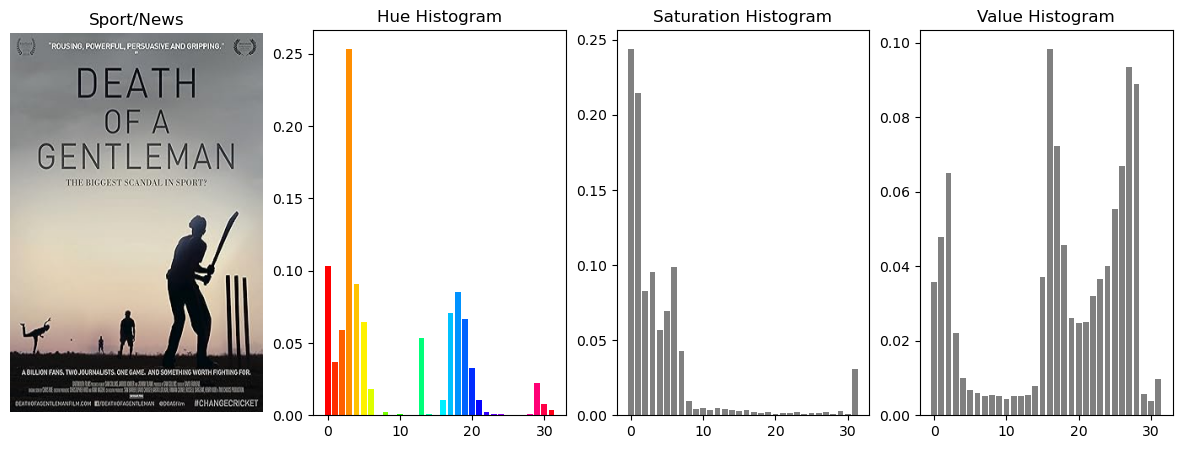

In [5]:
for image_index in range(0,10):
#     image_index = image_index

    image = images[image_index]
    histogram = histograms[image_index]


    # Extract Hue by summing across Saturation and Value
    hue_channel = histogram[0:32]

    # Extract Saturation by summing across Hue and Value
    saturation_channel = histogram[32:64]

    # Extract Value by summing across Hue and Saturation
    value_channel = histogram[64:96]

    hist_channels = [hue_channel, saturation_channel, value_channel]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    bins = len(hue_channel)
    hues = np.linspace(0, 360, bins)

    # Create the color map
    cmap = plt.cm.hsv  # Use the HSV colormap for colors


    axes[0].imshow(image)
    axes[0].axis('off')  # Hide axis for the image
    axes[0].set_title(df.iloc[image_index].reduced_genre)

    for i, (col, ax) in enumerate(zip(['Hue', 'Saturation', 'Value'], axes[1:])):

        if col == "Hue":
            ax.bar(np.arange(bins), hue_channel, color=cmap(hues / 360))
        else:
            ax.bar(np.arange(len(hist_channels[i])), hist_channels[i], color="grey")

        ax.set_title(f'{col} Histogram')

In [6]:
# Create a feature matrix
labels = np.array(df.reduced_genre).reshape(-1, 1)
labels.shape

(29265, 1)

In [7]:
features = np.array(histograms_summary)
features.shape

(29265, 9)

In [8]:
table_hsv = np.concatenate((labels, features), axis = 1)
df_hsv = pd.DataFrame(table_hsv)
df_hsv.columns = [
    'label',
    'mean_hue', 'sd_hue', 'skewness_hue', 
    'mean_saturation', 'sd_saturation', 'skewness_saturation', 
    'mean_value', 'sd_value', 'skewness_value'
]

df_hsv.head()

label   mean_hue     sd_hue   skewness_hue mean_saturation  \
0              Suspense  61.926952  50.229168   -4138.772105      148.128812   
1                 Drama  63.771647   57.61441   82380.400678      104.819753   
2        Sci-Fi/Fantasy  49.847432   70.99652  331975.426297       98.716486   
3              Suspense  56.011344  47.478837   25373.597817      156.208776   
4  Historical/Biography  16.371502  18.351998   43581.143695      212.346374   

  sd_saturation skewness_saturation  mean_value   sd_value  skewness_value  
0     109.30974      -443135.492288   53.432359  89.741972  1093140.460557  
1     62.223364       246509.476436  105.510859  67.725055    82107.055713  
2    116.402144        759435.50236   21.169955  56.039345   553649.843232  
3     66.298206      -245599.841212  123.064805  62.225475   -21519.730837  
4     49.294964       -197149.40415  109.887935  77.142235   127950.425466

In [9]:
# check min and max values
max_value_row = df_hsv.loc[df_hsv['mean_value'].idxmax()]
max_value_row

label                      Suspense
mean_hue                        0.0
sd_hue                          0.0
skewness_hue                    0.0
mean_saturation                 0.0
sd_saturation                   0.0
skewness_saturation             0.0
mean_value                253.25645
sd_value                  16.822923
skewness_value        -54702.573245
Name: 2233, dtype: object

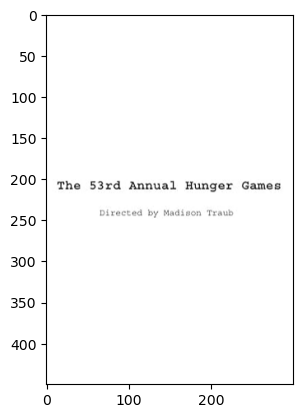

In [10]:
plt.imshow(images[2233])

In [11]:
min_value_row = df_hsv.loc[df_hsv['mean_value'].idxmin()]
min_value_row

label                       Suspense
mean_hue                    2.020404
sd_hue                      7.820693
skewness_hue             2444.931168
mean_saturation             8.621206
sd_saturation              40.001099
skewness_saturation    330144.108253
mean_value                  1.805858
sd_value                   15.082665
skewness_value          43927.529233
Name: 21242, dtype: object

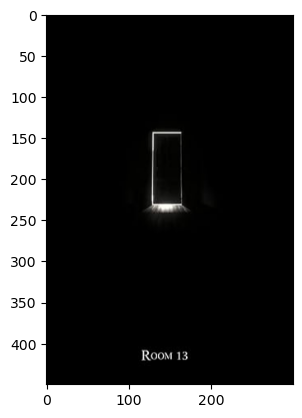

In [12]:
plt.imshow(images[21242])

In [13]:
mean_values = df_hsv.groupby('label')[['mean_hue', 'mean_saturation', 'mean_value']].mean()
mean_values

mean_hue mean_saturation  mean_value
label                                                      
Action/Adventure      59.568793      104.124157  135.017089
Comedy/Romance         55.29035       96.991057  149.053077
Drama                  53.19953       92.038001  132.666465
Historical/Biography  50.475364       86.019575  131.594047
Music/Musical         57.040297       97.241226  125.414357
Sci-Fi/Fantasy        62.314655      102.655017  114.915367
Sport/News            55.920888       92.430512  136.863779
Suspense               55.21468      101.176412  100.002413
War/Crime             51.880404       92.551339  115.878962
Western/Family        53.397091       99.359396  149.448787

/var/folders/4m/yp2tjgp53mqd_cn82ymt0ffh0000gn/T/ipykernel_90883/2072101493.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_hsv.groupby("label").apply(lambda x: x.sample(200, random_state=42)).reset_index(drop=True)


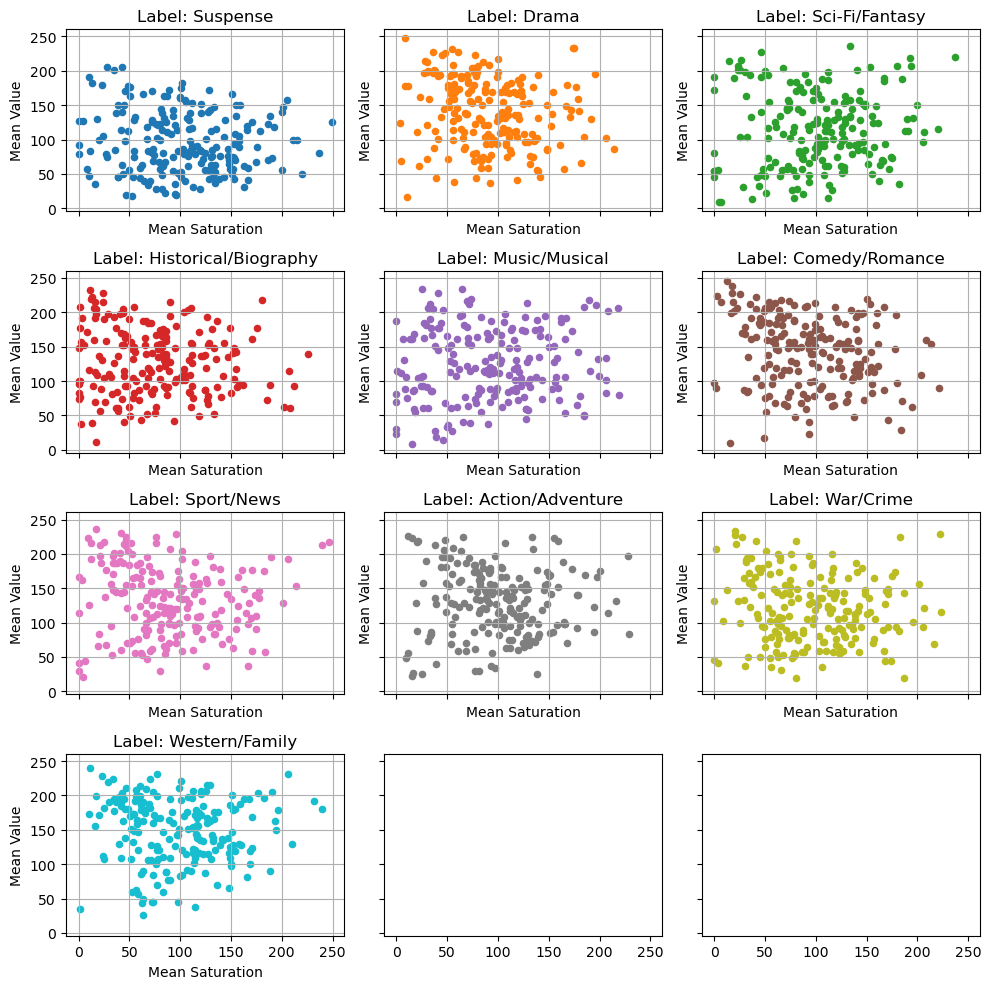

In [14]:
# Plot

# Sample 100 points from each label
sampled_df = df_hsv.groupby("label").apply(lambda x: x.sample(200, random_state=42)).reset_index(drop=True)

labels = df_hsv.label.unique()




fig, axes = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Unique colors for each label using seaborn color palette
colors = sns.color_palette("tab10", len(labels))

# Plot each label in its own subplot
for i, label in enumerate(labels):
    ax = axes[i]
    
    # Filter DataFrame for current label
    label_df = sampled_df[sampled_df["label"] == label]
    
    # Scatter plot for the label
    ax.scatter(label_df["mean_saturation"], label_df["mean_value"], color=colors[i], s=20, label=f"Label: {label}")
    
    # Titles and labels
    ax.set_title(f"Label: {label}", fontsize=12)
    ax.set_xlabel("Mean Saturation")
    ax.set_ylabel("Mean Value")
    ax.grid(True)
    
# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
# hog features

# We assume that different genres have distinct visual styles. Histogram of gradient can 
# captures these by capturing for example:
# - Edges: action movies might have sharper edges and more pronounced contrasts compared to drama posters which might have softer gradients and smoother transitions
# - Text Style: fonts and layouts might even be a cue rather than a distraction

In [16]:
hog_features = []
hog_images = []

for i in range(0, len(images)):
    
    im_gray = cv2.cvtColor(np.array(images[i]), cv2.COLOR_RGB2GRAY) / 255.0
    
#     im_gray = np.array(images[i].convert("L")) / 255.0
    
    height, width = im_gray.shape
    
    # We have to clear more images with a min width and hight 
    crop_width = 300
    crop_height = 400
    start_x = (width - crop_width) // 2
    start_y = (height - crop_height) // 2
    
    im_cropped = im_gray[start_y:start_y + crop_height, start_x:start_x + crop_width]
    

    fd, hog_image = hog(im_cropped, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)
    

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 1))
    
    hog_features.append(fd)
    hog_images.append(hog_image_rescaled)

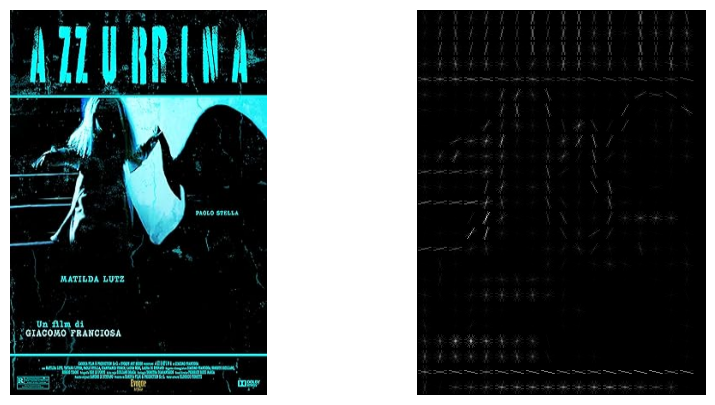

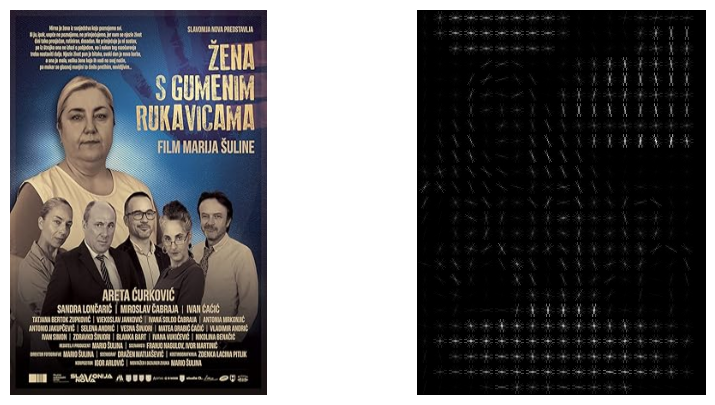

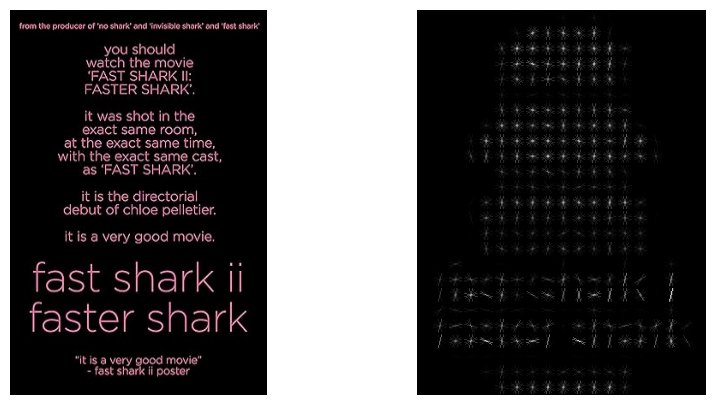

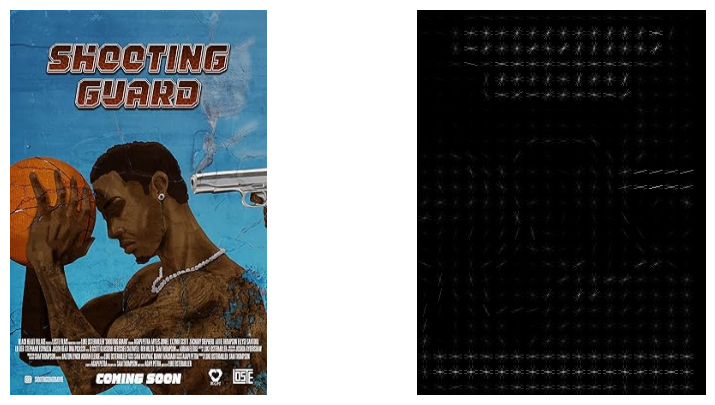

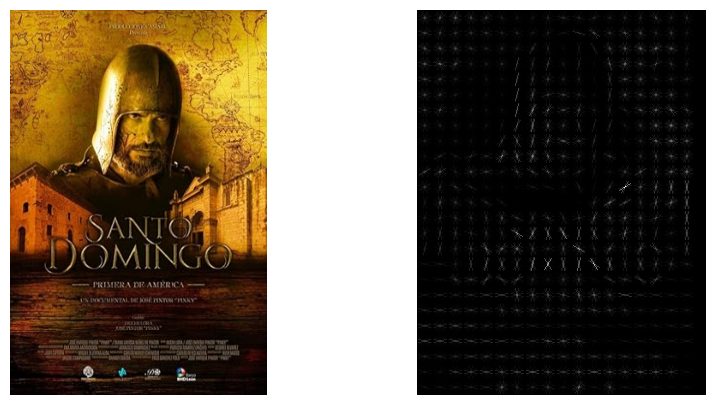

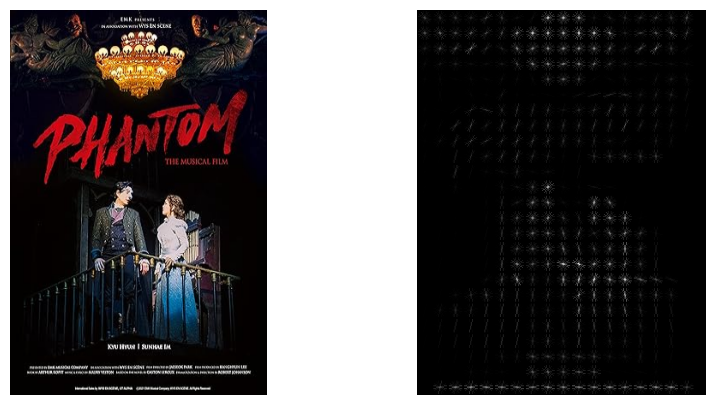

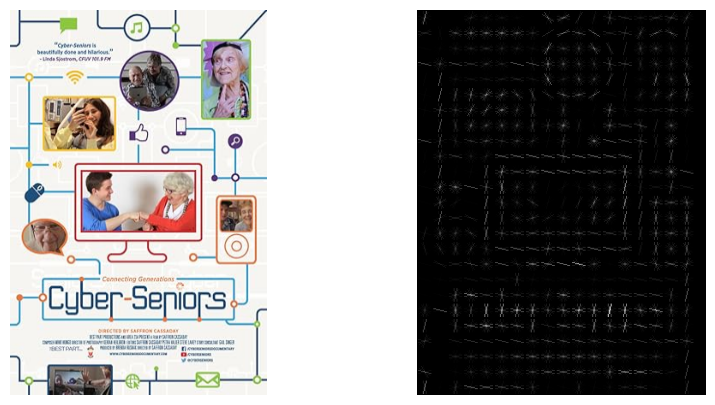

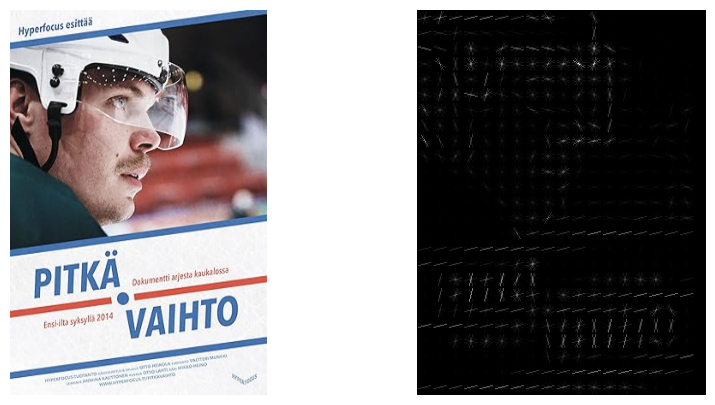

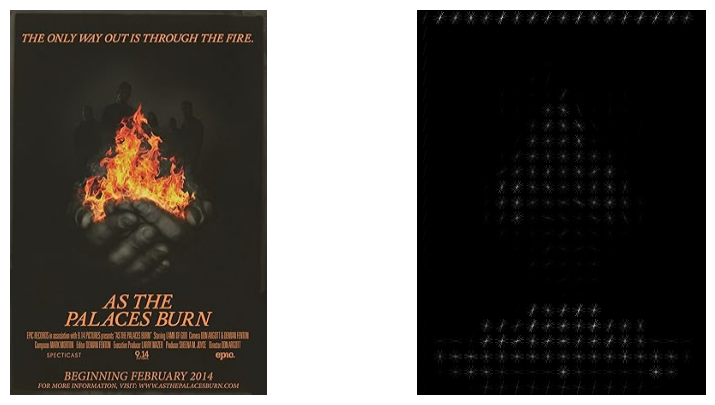

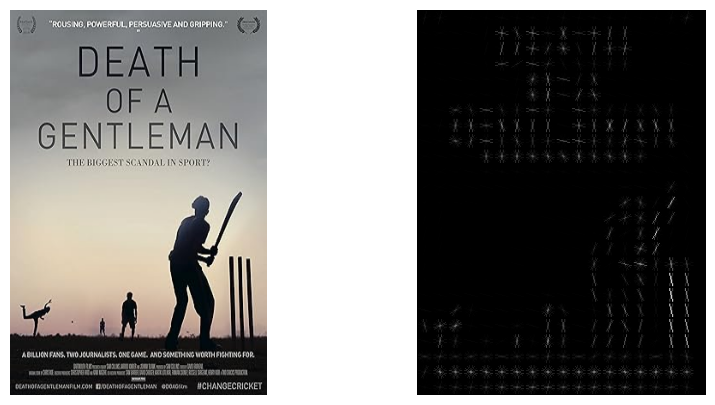

In [17]:
for i in range(0,10):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(hog_images[i], cmap='gray')
    plt.axis('off')
    plt.show()

In [18]:
# for i in range(1000):
#     print(f"Original Image Shape: {np.array(images[i]).shape}")
#     print(f"Hog feature shape: {hog_features[i].shape}")
#     print("--"*20)

In [19]:
features = np.array(hog_features)

In [20]:
features.shape

(29265, 3600)

In [21]:
labels = np.array(df.reduced_genre).reshape(-1, 1)
table_hog = np.concatenate((labels, features), axis = 1)
df_hog = pd.DataFrame(table_hog)
df_hog.rename(columns={df_hog.columns[0]: "label"}, inplace=True)

df_hog.head()

label         1         2         3         4         5  \
0              Suspense  0.431061  0.431061   0.34108  0.152136  0.338361   
1                 Drama  0.400467  0.217867  0.387912  0.157415  0.368488   
2        Sci-Fi/Fantasy       0.5       0.0       0.5       0.0       0.5   
3              Suspense   0.16188  0.101587  0.370577  0.620885  0.620885   
4  Historical/Biography  0.353553  0.353553  0.353553  0.353553  0.353553   

          6         7         8         9  ...      3591      3592      3593  \
0  0.052681  0.431061  0.431061  0.404434  ...  0.372349  0.372349  0.400221   
1  0.400467  0.400467  0.400467  0.362167  ...   0.33711  0.112204  0.392258   
2       0.0       0.5       0.0       0.5  ...       0.0       0.0       0.0   
3  0.213269  0.061855   0.07643    0.4294  ...   0.30269  0.394585  0.368036   
4  0.353553  0.353553  0.353553  0.370568  ...  0.330721  0.191258  0.398769   

       3594      3595      3596      3597      3598      3599      3600  
0  0.337502   0.26205  0.400221  0.400221  0.313224  0.280368  0.400221  
1  0.333438  0.392258  0.323365  0.392258  0.392258  0.310388  0.269162  
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
3  0.368036  0.368036  0.368036  0.368036  0.368036  0.227694  0.368036  
4  0.277678  0.409612  0.409612  0.409612  0.378216  0.329684  0.093778  

[5 rows x 3601 columns]

## Models

## Logistic Regression with HSV vector

In [22]:
df_hsv.head()

label   mean_hue     sd_hue   skewness_hue mean_saturation  \
0              Suspense  61.926952  50.229168   -4138.772105      148.128812   
1                 Drama  63.771647   57.61441   82380.400678      104.819753   
2        Sci-Fi/Fantasy  49.847432   70.99652  331975.426297       98.716486   
3              Suspense  56.011344  47.478837   25373.597817      156.208776   
4  Historical/Biography  16.371502  18.351998   43581.143695      212.346374   

  sd_saturation skewness_saturation  mean_value   sd_value  skewness_value  
0     109.30974      -443135.492288   53.432359  89.741972  1093140.460557  
1     62.223364       246509.476436  105.510859  67.725055    82107.055713  
2    116.402144        759435.50236   21.169955  56.039345   553649.843232  
3     66.298206      -245599.841212  123.064805  62.225475   -21519.730837  
4     49.294964       -197149.40415  109.887935  77.142235   127950.425466

In [23]:
df_hsv.label.value_counts()

label
Drama                   10792
Comedy/Romance           4919
Historical/Biography     3369
Suspense                 2534
Action/Adventure         2331
Music/Musical            1750
War/Crime                1371
Sport/News                833
Sci-Fi/Fantasy            731
Western/Family            635
Name: count, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [25]:
# encode the genres
label_encoder = LabelEncoder()
df_hsv['label_encoded'] = label_encoder.fit_transform(df_hsv['label'])
df_hsv.head()

label   mean_hue     sd_hue   skewness_hue mean_saturation  \
0              Suspense  61.926952  50.229168   -4138.772105      148.128812   
1                 Drama  63.771647   57.61441   82380.400678      104.819753   
2        Sci-Fi/Fantasy  49.847432   70.99652  331975.426297       98.716486   
3              Suspense  56.011344  47.478837   25373.597817      156.208776   
4  Historical/Biography  16.371502  18.351998   43581.143695      212.346374   

  sd_saturation skewness_saturation  mean_value   sd_value  skewness_value  \
0     109.30974      -443135.492288   53.432359  89.741972  1093140.460557   
1     62.223364       246509.476436  105.510859  67.725055    82107.055713   
2    116.402144        759435.50236   21.169955  56.039345   553649.843232   
3     66.298206      -245599.841212  123.064805  62.225475   -21519.730837   
4     49.294964       -197149.40415  109.887935  77.142235   127950.425466   

   label_encoded  
0              7  
1              2  
2              5  
3              7  
4              3

In [26]:
# balance the dataset
n = 635
df_hsv_sampled = df_hsv.groupby('label', group_keys=False).sample(n=n, random_state=42)

In [27]:
# create feature and label vectors
X = df_hsv_sampled[['mean_hue', 'mean_saturation', 'mean_value']]
y = df_hsv_sampled['label_encoded']

In [28]:
y.value_counts()

label_encoded
0    635
1    635
2    635
3    635
4    635
5    635
6    635
7    635
8    635
9    635
Name: count, dtype: int64

In [29]:
# split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# fit logistic regression model
log_reg_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg_classifier.fit(X_train_scaled, y_train)

/Users/richardlumpi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [32]:
# predictions
y_pred = log_reg_classifier.predict(X_test_scaled)

In [33]:
# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.15984251968503937


In [34]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                      precision    recall  f1-score   support

    Action/Adventure       0.09      0.05      0.06       127
      Comedy/Romance       0.11      0.20      0.14       127
               Drama       0.33      0.01      0.02       127
Historical/Biography       0.21      0.15      0.17       127
       Music/Musical       0.14      0.01      0.01       127
      Sci-Fi/Fantasy       0.16      0.17      0.17       127
          Sport/News       0.14      0.02      0.04       127
            Suspense       0.20      0.50      0.29       127
           War/Crime       0.14      0.19      0.16       127
      Western/Family       0.17      0.30      0.22       127

            accuracy                           0.16      1270
           macro avg       0.17      0.16      0.13      1270
        weighted avg       0.17      0.16      0.13      1270



In [35]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg_classifier.coef_[0]})
print("\nFeature Importance:\n", feature_importance)


Feature Importance:
            Feature  Coefficient
0         mean_hue     0.085696
1  mean_saturation     0.097404
2       mean_value     0.078820


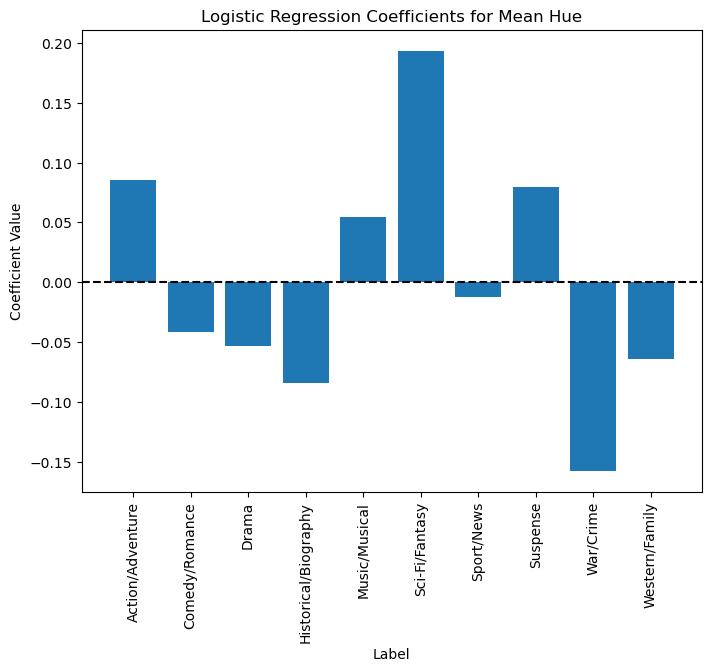

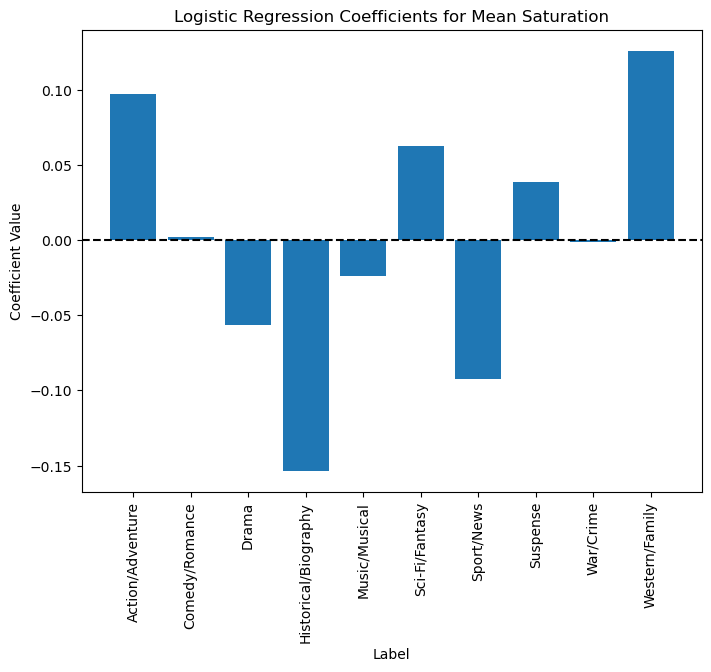

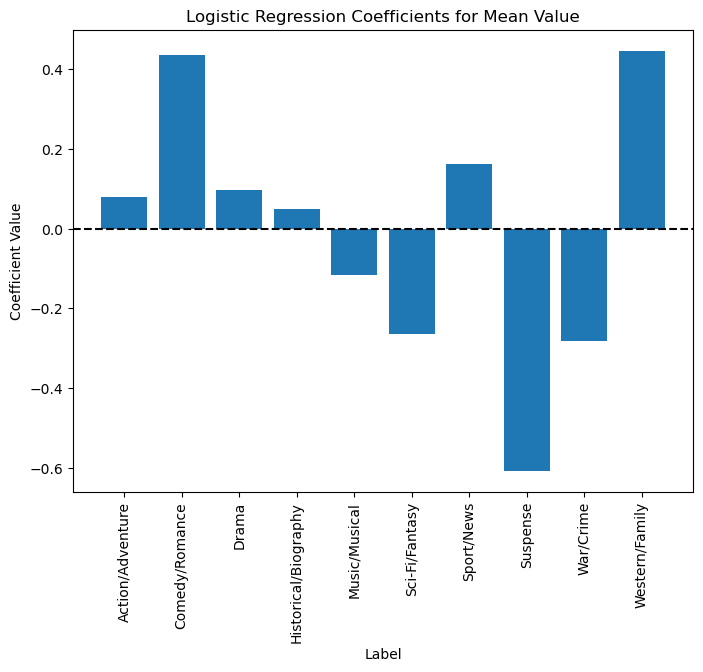

In [36]:
# visualise the feature parameters

class_labels = label_encoder.classes_  # Genre names
feature_names = ["Mean Hue", "Mean Saturation", "Mean Value"]

# Extract model coefficients (weights)
coefficients = log_reg_classifier.coef_ 

# Plot each feature's coefficients on its own figure
for feature_idx, feature_name in enumerate(feature_names):
    plt.figure(figsize=(8, 6))
    
    # Plot coefficients for each class for the current feature
    plt.bar(class_labels, coefficients[:, feature_idx])
    
    plt.xticks(rotation=90)
    
    plt.axhline(y=0, color='black', linestyle='--')
    
    # Formatting
    plt.xlabel('Label')
    plt.ylabel('Coefficient Value')
    plt.title(f'Logistic Regression Coefficients for {feature_name}')
    plt.show()


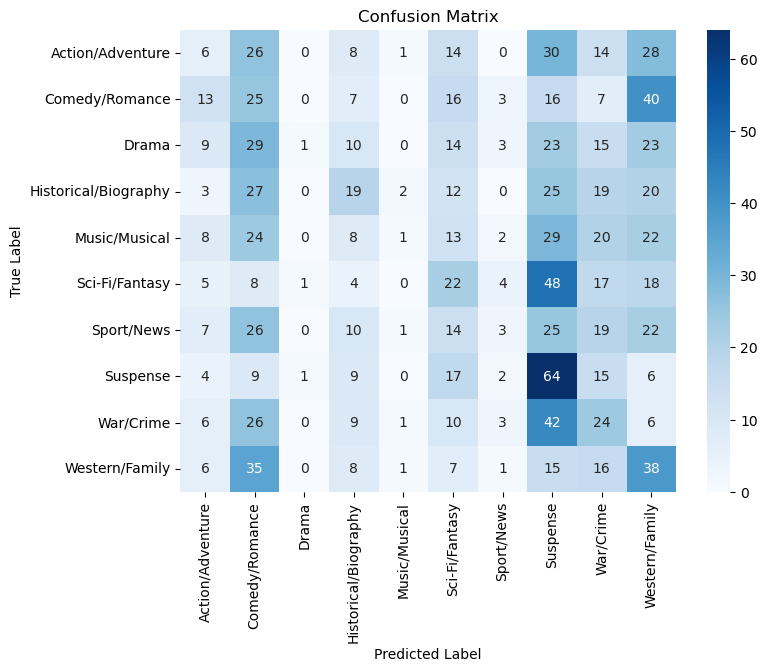

In [37]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Logistic Regression with HOG feature vector

Testing hypothesis that some genres have more pronounced edges and contours than others (e.g. movie posters with explosions)

In [38]:
action_mean = np.array(np.mean(df_hog[df_hog.label == "Action/Adventure"].iloc[:, 1:3601], axis=0))
comedy_mean = np.mean(df_hog[df_hog.label == "Comedy/Romance"].iloc[:, 1:3601], axis=0)

print(f"Action mean: {np.mean(action_mean)}")
print(f"Comedy mean: {np.mean(comedy_mean)}")



# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(action_mean.reshape((300, 400)), cmap='hot')
# plt.title("Average HOG - Action Movies")

# plt.subplot(1, 2, 2)
# plt.imshow(comedy_mean.reshape((hog_image_shape)), cmap='hot')
# plt.title("Average HOG - Comedy Movies")

# plt.show()

Action mean: 0.3176381693102561
Comedy mean: 0.30800886600813066


In [39]:
# encode the genres
label_encoder = LabelEncoder()
df_hog['label_encoded'] = label_encoder.fit_transform(df_hog['label'])
df_hog.head()

label         1         2         3         4         5  \
0              Suspense  0.431061  0.431061   0.34108  0.152136  0.338361   
1                 Drama  0.400467  0.217867  0.387912  0.157415  0.368488   
2        Sci-Fi/Fantasy       0.5       0.0       0.5       0.0       0.5   
3              Suspense   0.16188  0.101587  0.370577  0.620885  0.620885   
4  Historical/Biography  0.353553  0.353553  0.353553  0.353553  0.353553   

          6         7         8         9  ...      3592      3593      3594  \
0  0.052681  0.431061  0.431061  0.404434  ...  0.372349  0.400221  0.337502   
1  0.400467  0.400467  0.400467  0.362167  ...  0.112204  0.392258  0.333438   
2       0.0       0.5       0.0       0.5  ...       0.0       0.0       0.0   
3  0.213269  0.061855   0.07643    0.4294  ...  0.394585  0.368036  0.368036   
4  0.353553  0.353553  0.353553  0.370568  ...  0.191258  0.398769  0.277678   

       3595      3596      3597      3598      3599      3600 label_encoded  
0   0.26205  0.400221  0.400221  0.313224  0.280368  0.400221             7  
1  0.392258  0.323365  0.392258  0.392258  0.310388  0.269162             2  
2       0.0       0.0       0.0       0.0       0.0       0.0             5  
3  0.368036  0.368036  0.368036  0.368036  0.227694  0.368036             7  
4  0.409612  0.409612  0.409612  0.378216  0.329684  0.093778             3  

[5 rows x 3602 columns]

In [40]:
# balance the dataset
n = 635
df_hog_sampled = df_hog.groupby('label', group_keys=False).sample(n=n, random_state=42)

In [41]:
# create feature and label vectors
X = df_hog_sampled.iloc[:, 1:3601]
y = df_hog_sampled['label_encoded']

In [42]:
X.shape

(6350, 3600)

In [43]:
# split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# fit logistic regression model
log_reg_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg_classifier.fit(X_train_scaled, y_train)

/Users/richardlumpi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [46]:
# predictions
y_pred = log_reg_classifier.predict(X_test_scaled)

In [47]:
# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.13070866141732285


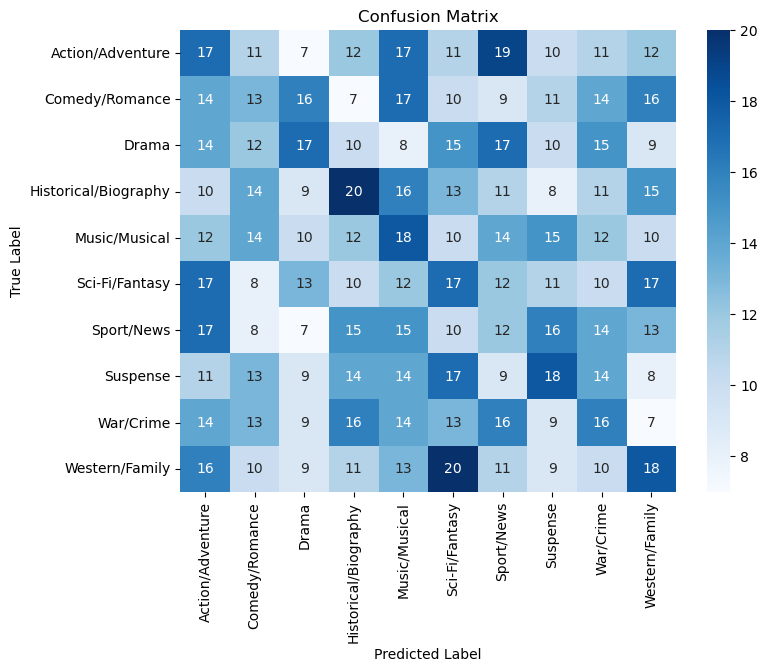

In [48]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()